# Sample_Kaggle_Submission-DSI-9

### <font color='blue'> 01_EDA _and_Cleaning.ipynb 

## <font color='green'> Content:

1 [Exploratory Data Analysis (EDA):](#Exploratory-Data-Analysis-(EDA):)
--------------------------------------------------- 
* [Import Packages and Data](#Import-Packages-and-Data)
* [High Level Checks](#High-Level-Checks)
* [Investigating Target Variable (SalePrice)](#Investigating-Target-Variable-(SalePrice))
* [Investigating Features: Correlation and Univariate Distribution](#Investigating-Features:-Correlation-and-Univariate-Distribution)
* [Handling Outliers](#Handling-Outliers)

# [Data Cleaning](#Data-Cleaning)

-----------------------------------------------
* [Dealing with Years](#Dealing-with-Years)
* [Missing Values and Data Cleaning:](#Missing-Values-and-Data-Cleaning:)
* [Checking Missing Values](#Checking-Missing-Values)
* [Imputing Missing Values](#Missing-Values-and-Data-Cleaning)
* [Store Clean Data](#Store-Clean-Data)

 # Exploratory Data Analysis (EDA):

## Import Packages and Data

In [1]:
# upload libraries 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew, boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, Imputer
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
#Read the training data set and testing data set
df_train = pd.read_csv("./datasets/train.csv") # This is what we'll need to work with!
df_test = pd.read_csv("./datasets/test.csv") # We won't touch this until after we've created model

In [3]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

## High Level Checks

In [4]:
## Examine dimensions

print ('The train dataset has {0} rows and {1} columns'.format(df_train.shape[0],df_train.shape[1]))
print ('-----------------------------------------------')
print ('The test dataset has {0} rows and {1} columns'.format(df_test.shape[0],df_test.shape[1]))

The train dataset has 2051 rows and 81 columns
-----------------------------------------------
The test dataset has 879 rows and 80 columns


In [5]:
# Quick check to see which column is in train.csv but not test.csv
set(df_train.columns) - set(df_test.columns)

{'SalePrice'}

In [6]:
#check for dubpliactes in train
idsUnique = len(set(df_train.Id))
idsTotal = df_train.shape[0]
idsdupe = idsTotal - idsUnique
print(idsdupe)

0


In [7]:
#check for dubpliactes in test
idsUnique = len(set(df_test.Id))
idsTotal = df_test.shape[0]
idsdupe = idsTotal - idsUnique
print(idsdupe)

0


In [8]:
# Resetting the index for our data frame according to one of the columns (Id)
df_train.set_index('Id', inplace = True)
df_test.set_index('Id', inplace = True)

### Observation from Initial Data Exploration 

#### There are two datasets.

1. Train.csv is the primary dataset used for the project.The train.csv dataset contains all the housing features to explore, including the sales price, which is our target variable.

2. Test.csv dataset is included for validation purposes. This is the file upon which I will make my conclusion. It does not have the 'SalePrice' column. The purpose of this project is to generate a model that can be tested with test.csv to see how closely the predictions match prices on unseen data. 


**Data Types** : objects, numeric(floats, integers)<br>
**Variable Types** : nominal, ordinal,  discrete, and continuous <br>
**Missing values** : NaN observed in columns of both data types<br>
**No dubpliactes found**

In [9]:
# formating column names for consistency.

df_train.rename(columns= {col: col.lower().replace(' ','_') for col in df_train.columns}, inplace=True)
df_test.rename(columns= {col: col.lower().replace(' ','_') for col in df_test.columns}, inplace=True)

In [10]:
#find how many categorical and numerical data we have 
df_train.dtypes.value_counts()

object     42
int64      27
float64    11
dtype: int64

 The train data has 79 columns which include 42 objects, 38 numerical variables(27+11)

In [11]:
#find how many categorical and numerical data we have 
df_test.dtypes.value_counts()

object     42
int64      34
float64     3
dtype: int64

The test data has 79 columns which include 42 objects, 37 numerical variables. However, we can observe that integers is more in test model than in train model. 

Based on the initial observation I can say that our datasets are grouped into the folowing types:
   * Continuous,
   * Nominal,
   * Categorical, 
   * Ordinal

## Checking Missing Values

In [12]:
#Lets check missing how many missing values I have in train and test model.

print(f'{df_train.isnull().sum().sort_values(ascending=False).sum()} missing values in train model.')
print(f'{df_test.isnull().sum().sort_values(ascending=False).sum()} missing values in test model.')

9822 missing values in train model.
4175 missing values in test model.


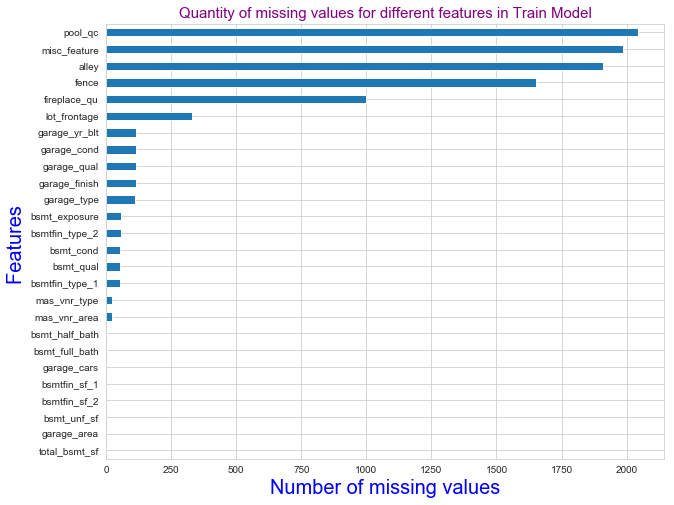

In [13]:
## For better understanding missing values for different features in Train Model
## lets visualize it 

#sort counts
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

## Plot this as a bar chart for each feature
plt.figure(figsize=(10,8))
missing.plot.barh()
plt.title("Quantity of missing values for different features in Train Model",fontsize = 15,color='Purple')
plt.xlabel('Number of missing values', fontsize = 20,color='blue')
plt.ylabel('Features ', fontsize = 20,color='blue');


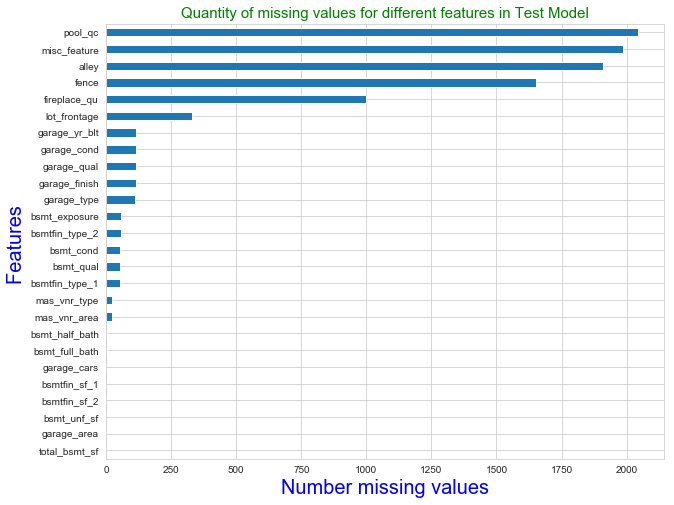

In [14]:
# Visualization of missing values for different features in Test Model
missing_test = df_test.isnull().sum()
missing_test = missing_test[missing_test > 0]
missing_test.sort_values(inplace=True)
plt.figure(figsize=(10,8))
missing.plot.barh()
plt.title("Quantity of missing values for different features in Test Model",fontsize = 15,color='Green')
plt.xlabel('Number missing values', fontsize = 20,color='blue')
plt.ylabel('Features ', fontsize = 20,color='blue');

Based on the initial classification of our data set, we know that there are categorical and numerical data types. This information prevents us from filling all missing data with '0'. For example "Alley" or "Pool QC" should be filled with "NA" according our data distionary. I consider to  impute '0' for float or integer data type such as area, square footage, number of cars, etc.

### Categorical data
With qualitative variables we can implement two methods. First one is to check distribution of SalePrice with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

## Investigating Target Variable (SalePrice)

Sale price is the value we are looking to predict in our project, so it made sense to examine this variable first.

In [15]:
#descriptive statistics summary
df_train['saleprice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

This information tells us that average price for the house from 2051 houses we analize is **$181,469**. 

The minimum price that house was solved is **12,789** dollars and the most expensive house was sold for **$611657**

In [16]:
#lets see the price that is appears more often
print(f"Mode SalesPrice:${df_train['saleprice'].mode()}")

Mode SalesPrice:$0    130000
dtype: int64


The cheapest house sold for $12789 and the most expensive for $611657
The average sales price is $181469.70160897123,  while median is $162500.0


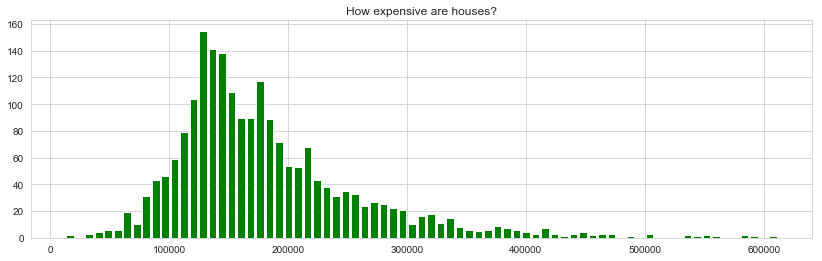

In [17]:
### How expensive are houses?
print(f'The cheapest house sold for ${df_train.saleprice.min()} and the most expensive for ${df_train.saleprice.max()}')
print(f'The average sales price is ${df_train.saleprice.mean()},  while median is ${df_train.saleprice.median()}')
df_train.saleprice.hist(bins=75, rwidth=.8, figsize=(14,4),color='green')
plt.title('How expensive are houses?')
plt.show()

The average house has 1,499 sq_ft of space, the median 1,444 sq ft
The biggest house has 5,642 sq_ft of space, the smallest 334 sq ft


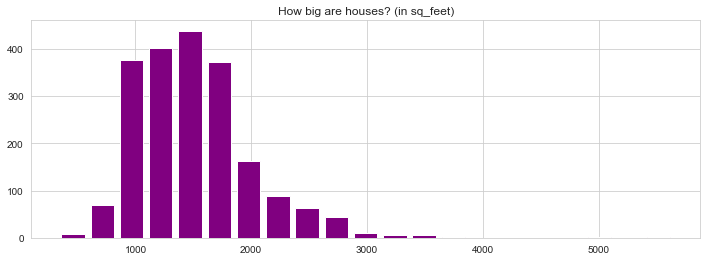

In [18]:
# How big are houses?
print('The average house has {:,.0f} sq_ft of space, the median {:,.0f} sq ft'.format(
    df_train.gr_liv_area.mean(), df_train.gr_liv_area.median()))
print('The biggest house has {:,.0f} sq_ft of space, the smallest {:,.0f} sq ft'.format(
    df_train.gr_liv_area.max(), df_train.gr_liv_area.min()))
df_train.gr_liv_area.hist(bins=21, rwidth=.8, figsize=(12,4), color='purple')
plt.title('How big are houses? (in sq_feet)')
plt.show()

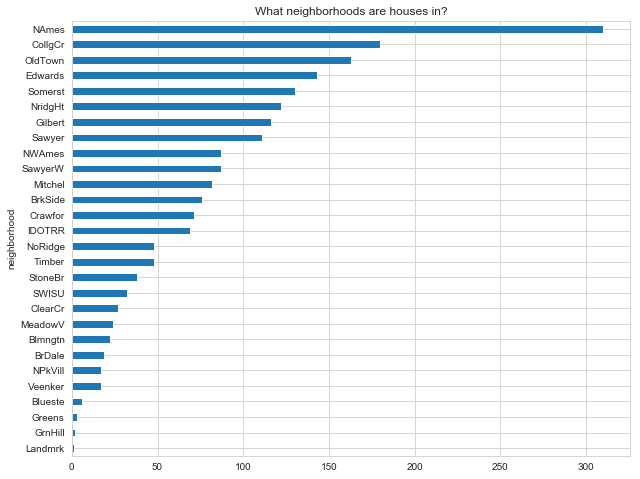

In [19]:
# Where are houses?
df_train.groupby('neighborhood').size().\
    sort_values().\
    plot(kind='barh', figsize=(10,8))
plt.title('What neighborhoods are houses in?')
plt.show()

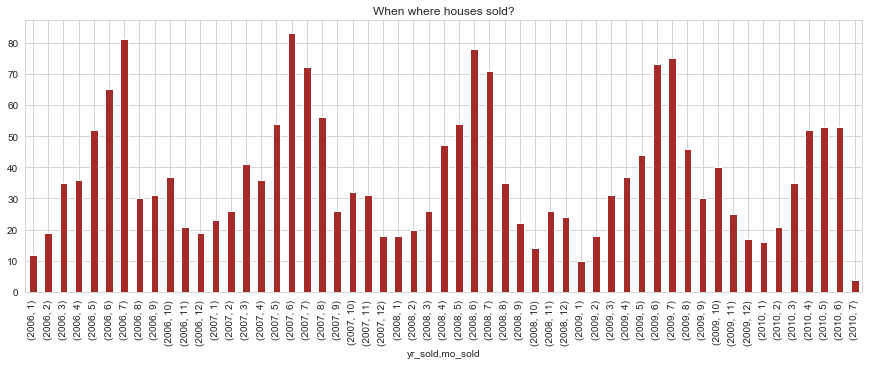

In [20]:
# When where houses sold?
df_train.groupby(['yr_sold','mo_sold']).size().plot(kind='bar', figsize=(15,5),color= 'brown')
plt.title('When where houses sold?')

plt.show()

## Investigating Distribution of Sale Price

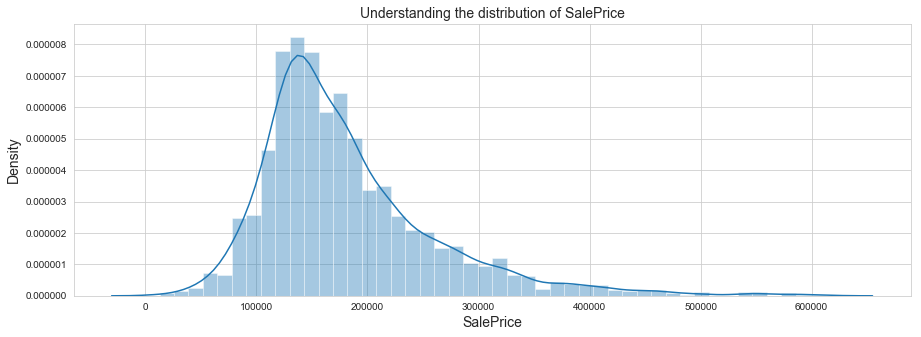

In [21]:
# plot distribution  of Sale Price
fig = plt.figure(figsize=(15,5))
sns.distplot(df_train['saleprice'])
plt.xlabel("SalePrice", size=14)
plt.ylabel("Density", size=14);
plt.title('Understanding the distribution of SalePrice', size = 14);


It seems our Sale Price is not normally distributed.

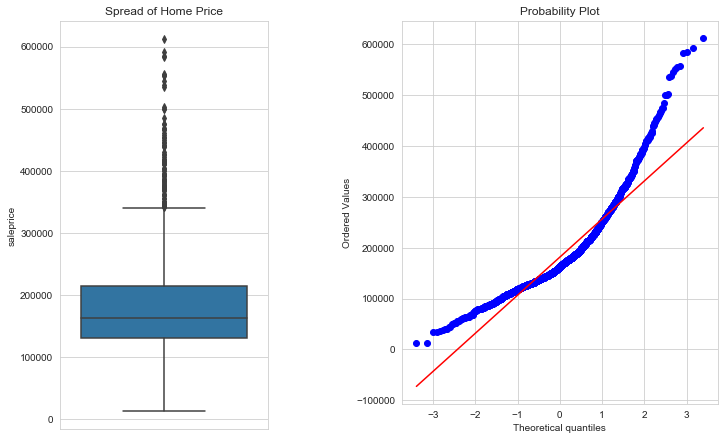

In [22]:
## double check distribution using quantile and boxplot showing spread of homes
fig = plt.figure(constrained_layout=True, figsize=(10,6))

plt.subplot(1,2,1)

plt.subplot(1,2,2)
stats.probplot((df_train['saleprice']), plot=plt)
ax= plt.subplot(1,3,1)
sns.boxplot(df_train.loc[:,'saleprice'], orient='v', ax = ax )

plt.title("Spread of Home Price")
plt.show();

In [23]:
#kurtosis
print("Kurtosis: %f" % df_train['saleprice'].kurt())

Kurtosis: 3.579003


In [24]:
#skewness confirms not normal distribution 
print(f"The skewness of SalePrice is {df_train.loc[:,'saleprice'].skew()}")

The skewness of SalePrice is 1.5575514385863427


**Observations:**
- The target variable, SalePrice *is not* normally distributed.
- Our target variable is right-skewed.
- Quantile plot shows that the price value is not linear.
- There are multiple outliers in the variable

**These means the errors will not be normally distributed either. I will need to standardize the values in the training data in order to create a good model. Lets correct it by taking the log.**

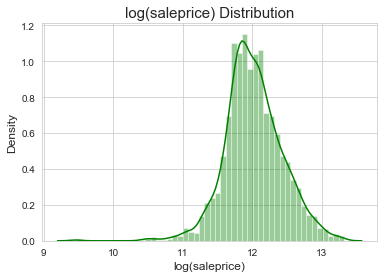

In [25]:
# Plot log SalePrice distribution
sns.distplot(np.log(df_train['saleprice']), color="green", kde=True)
plt.title("log(saleprice) Distribution", size=15)
plt.xlabel("log(saleprice)", size=12)
plt.ylabel("Density", size=12);

Once the log was taken, we were no longer violating the normality assumption for regressions. After the log transformation, the price distribution looks much more linearly distributed

### Action

- Investigate relationship between data.
- Compare my datasets, clean data and make changes in each of them.It will help me to create engineered features and modelling .

## Investigating Features: Correlation and Univariate Distribution

First step will be to take a look at relatiships between variables

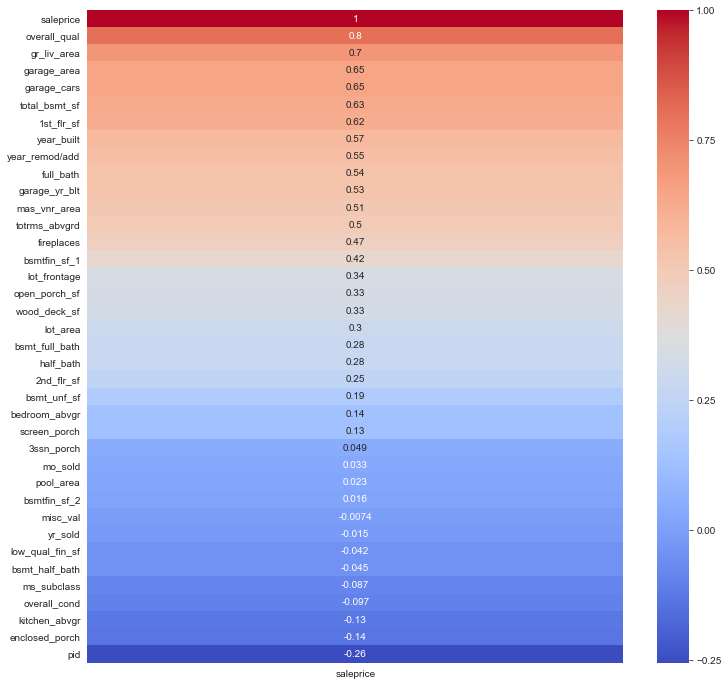

In [26]:
# check correlation of each numeric variables with saleprice
plt.figure(figsize = (12, 12))

sns.heatmap(df_train.corr()[['saleprice']].sort_values('saleprice', ascending=False), 
            cmap = 'coolwarm', 
            annot = True)
# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12);

Based on heatmap we can identify variables that have the strongest correlation. 
A number of features related to the quality of the home and the size influences the sale price, which might impact our predictions.
Strongest Predictors:
**Overall Quality and Gr Living Area**

Next we look at some of our features distribution.

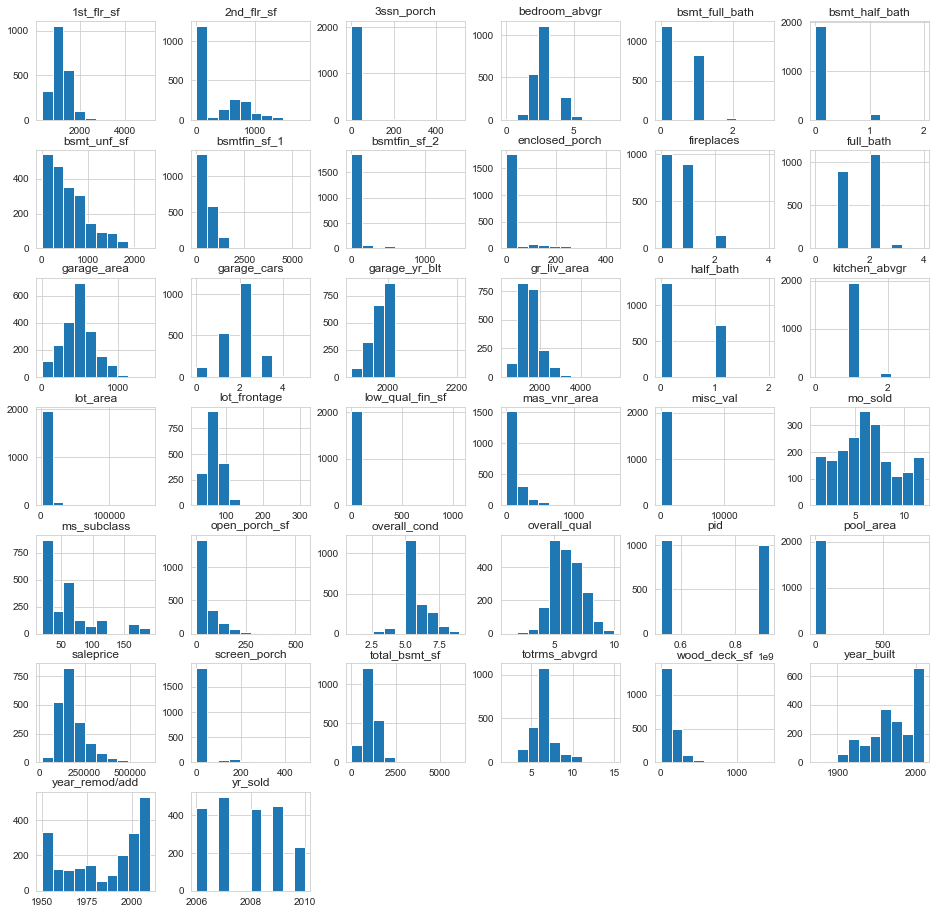

In [27]:
#Plot histogram for All Numerical Features:
df_train.hist(figsize=(16,16));

It is obvious skewness in predictor variables such as GrLivArea, 1stFlrSF, LotArea,Lot_Frontage.I will consider to apply logarithm transformation, which gonna help in fixing the skewness.

## Investigating Features: Bivariate Distributions

Next we look at how our features behave relative to our SalePrice.

/Users/juliazaytseva/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


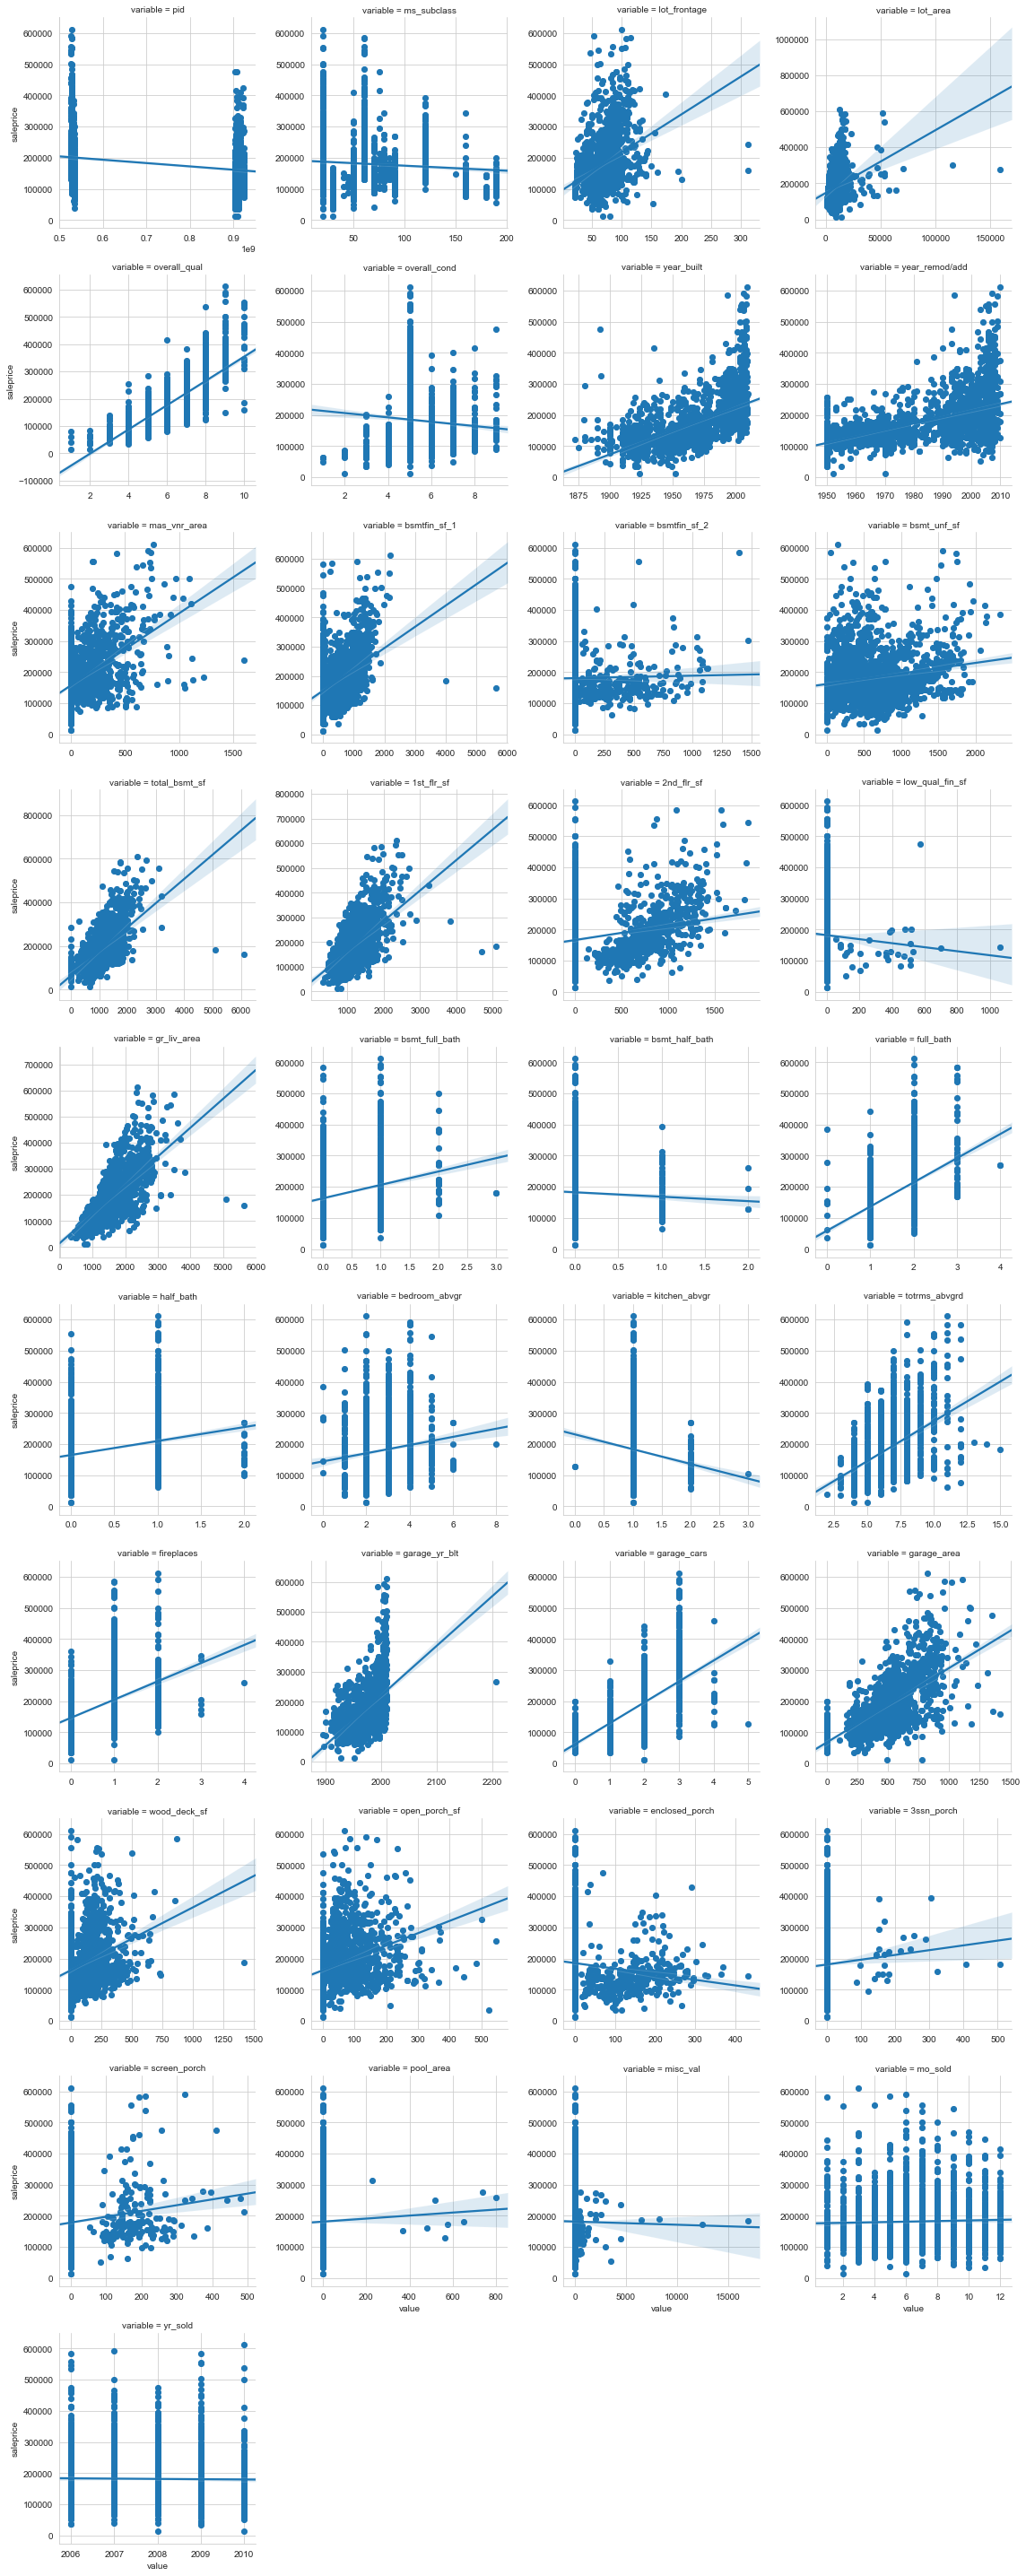

In [28]:
#Plot scatter plots for all numeric variables to determine if all variables are skewed.
#For categorical variables, we'll create a boxplot and understand their nature.


## code below was taken from Gigi
tr = df_train[df_train["saleprice"].isnull() == False]
y = tr["saleprice"]
tr = tr.select_dtypes(include=['float64', "int64"])
tr.drop("saleprice", axis=1, inplace=True)

f = pd.melt(pd.concat([tr,y],axis=1) , id_vars = ['saleprice'] , value_vars = tr.columns )
g = sns.FacetGrid(f, col = 'variable' , col_wrap = 4, size = 4,sharex=False , sharey=False)
g = g.map(plt.scatter, "value", "saleprice")
g.map(sns.regplot, 'value', 'saleprice', scatter_kws={'alpha':0.3})
plt.tight_layout();

This scatter plot helps us to see correlation of numerical variables with SalePrice. Features that represent years don't have a clear trend, but perhaps this suggests that dealing with these features as numerics isn't the right way to go about it - it makes more sense to view them as categorical variables. I will handle this in the Data Cleaning section.


Taking into account new findings such as Quality or Year  belongs to categorica type Lets take a lookat our Categoriacl Varibaes and its relationships with Saleprice.

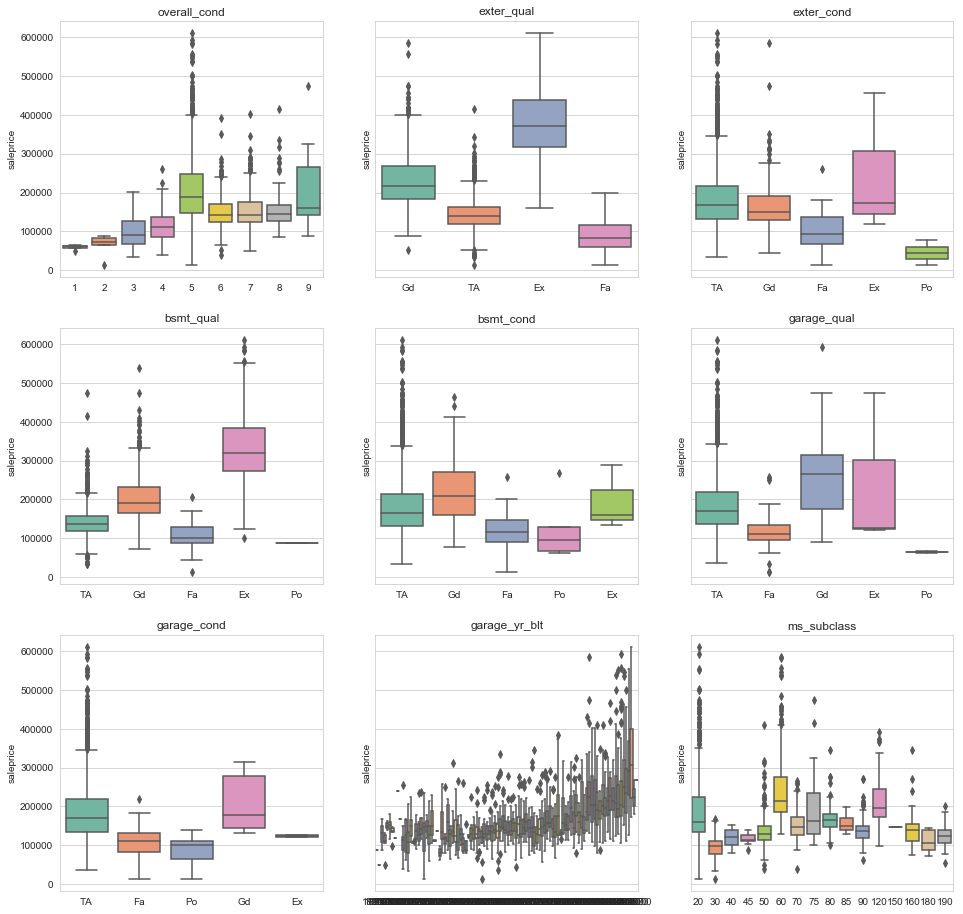

In [29]:
#Categorical Variables
fig, axes = plt.subplots(ncols=3, nrows=3, 
                         figsize=(4 * 4, 4 * 4), sharey=True)

axes = np.ravel(axes) # Ravel turns a matrix into a vector, which is easier to iterate

cols = ['overall_cond','exter_qual','exter_cond','bsmt_qual',
        'bsmt_cond','garage_qual','garage_cond', 'garage_yr_blt', 'ms_subclass','ms_zoning',
        'neighborhood','bldg_type','house_style','heating','electrical','sale_type']

for i, c in zip(np.arange(len(axes)), cols):
    ax = sns.boxplot(x=c, y='saleprice', data=df_train, ax=axes[i], palette="Set2")
    ax.set_title(c)
    ax.set_xlabel("")
    

### Observation
* Price is going up if quality of a house improves. However, some of houses with lower quality has higher value. It is outliers and our scatterplot and boxplots porved it obvous presence. 
* Our target variable shows an unequal level of variance across most predictor(independent) variable values.Outliners maybe result of missing data.I am going to investigate them.

## Handling Outliers

First, I need to take a look at the relationship of my variables.

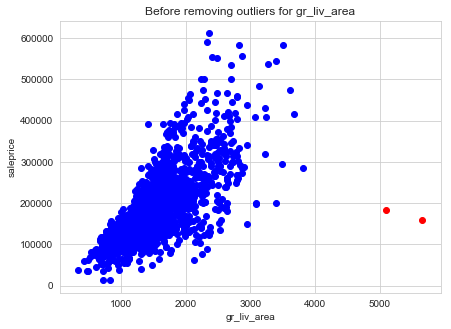

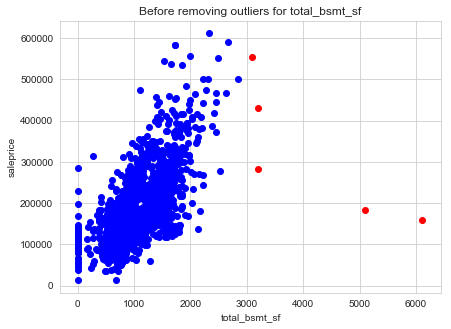

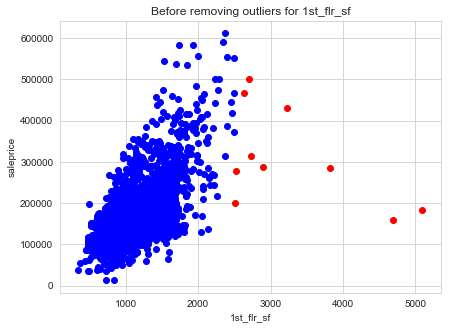

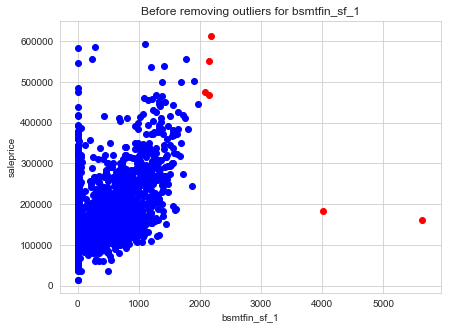

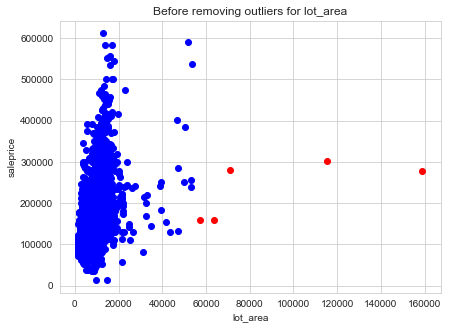

In [30]:
#plot scatterplot and identify outliers with red color
col_name = ['gr_liv_area','total_bsmt_sf','1st_flr_sf','bsmtfin_sf_1','lot_area']
outlier = [4500, 3000, 2500, 2000, 55000]
for i, c in zip(range(5), col_name):
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(np.abs(df_train[df_train[c] < outlier[i]][c]), np.array(df_train[df_train[c] < outlier[i]]['saleprice']), c='b')
    plt.scatter(np.abs(df_train[df_train[c] >= outlier[i]][c]), np.array(df_train[df_train[c] >= outlier[i]]['saleprice']), c='r')
    plt.title('Before removing outliers for '+c)
    plt.xlabel(c)
    plt.ylabel('saleprice')

Outliers wildly deviate from an otherwise strong positive trend so we should remove this before training our model.

In [31]:
#the following codes were used to identify outliers
##Check for outliers in lot area
#df_train.sort_values('lot_area', ascending = False)[['lot_area']].head()
## Check for outliers in 1st floor square footage
#df_train.sort_values('1st_flr_sf', ascending = False)[['gr_liv_area', '1st_flr_sf']].head()
# Check for outliers in GR Liv Area
#df_train.sort_values('gr_liv_area', ascending = False)[['gr_liv_area']].head()
#Use the similar structure of code for all outliers


In [32]:
# removing outliers
df_train = df_train[df_train['gr_liv_area'] < 4000]
df_train = df_train[df_train['lot_area'] < 100000]
df_train = df_train[df_train['total_bsmt_sf'] < 3000]
df_train = df_train[df_train['1st_flr_sf'] < 2500]
df_train = df_train[df_train['bsmtfin_sf_1'] < 2000]

#### Observations:
If the outliers are non-randomly distributed, they can decrease normality.
They can bias or influence estimates that may be of substantive interest
They can also impact the basic assumption of Regression and other statistical model assumptions.
I discovered a couple of extreme outliers after plotting the scatterplots vs. SalePrice and removed them. The rest will handle after cleaning my data and normalized skewed distributions by applying logarithms to variables.

# Data Cleaning

We recognized that some of numerical data should be treated as categorical. If some of these have NaN, we also can't just fill them with a year of 0! We'll therefore need to treat these as dummies eventually. Lets start with columns that have years.

## Dealing with Years

In [33]:
# Extract columns that are years 
yr_cols = [col for col in df_train.columns if ('yr' in col) or ('year' in col)]

# Peak into these to see that nothing odd is going on
df_train[yr_cols].describe()

,year_built,year_remod/add,garage_yr_blt,yr_sold
count,2032.000000,2032.000000,1918.000000,2032.000000
mean,1971.551181,1984.077264,1978.600626,2007.772638
std,30.207885,21.048476,25.468916,1.314045
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1964.000000,1961.000000,2007.000000
50%,1974.000000,1993.000000,1980.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [34]:
# Correct the typo in the cell with the garage built
df_train.loc[ df_train[df_train['garage_yr_blt'] == 2207].index, 'garage_yr_blt'] = 2007

# Check that it's okay now:
df_train[yr_cols].describe()

,year_built,year_remod/add,garage_yr_blt,yr_sold
count,2032.000000,2032.000000,1918.000000,2032.000000
mean,1971.551181,1984.077264,1978.496350,2007.772638
std,30.207885,21.048476,24.937182,1.314045
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1964.000000,1961.000000,2007.000000
50%,1974.000000,1993.000000,1980.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2010.000000,2010.000000


In [35]:
# For convinience I convert the data to string as we'll need to generate dummies for these later.
df_train[yr_cols] = df_train[yr_cols].astype(str)
df_test[yr_cols] = df_test[yr_cols].astype(str)

## Missing Values and Data Cleaning:

In [38]:
#missing value counts in each of these columns in train dataset
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


,Total,Percent
pool_qc,2025,0.996555
misc_feature,1969,0.968996
alley,1892,0.931102
fence,1635,0.804626
fireplace_qu,999,0.491634
lot_frontage,324,0.159449
garage_cond,114,0.056102
garage_finish,114,0.056102
garage_qual,114,0.056102
garage_type,113,0.055610


Based on this table I identified data that has 95% of missing value:

* alley
* misc_feature
* pool_qc

In [39]:
#missing value counts in each of these columns in test dataset
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_test.head(20)

,Total,Percent
pool_qc,875,0.995449
misc_feature,838,0.953356
alley,821,0.934016
fence,707,0.804323
fireplace_qu,422,0.480091
lot_frontage,160,0.182025
garage_finish,45,0.051195
garage_cond,45,0.051195
garage_qual,45,0.051195
garage_type,44,0.050057


In [40]:
#Function to change all NaN values in NUMERIC columns to 0
def nan_to_zer(df, list_of_cols):
    for lis in list_of_cols:
        
         # Exclude nulls and check type to see if float or int
        if df[df[lis].notnull()][lis].dtype == 'float64' or df[df[lis].notnull()][lis].dtype == 'int':
            df[lis].fillna(0, inplace = True)

In [41]:
nan_to_zer(df_train, ['lot_frontage',
 'alley',
 'mas_vnr_type',
 'mas_vnr_area',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_sf_1',
 'bsmtfin_type_2',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'fireplace_qu',
 'garage_type',
 'garage_yr_blt',
 'garage_finish',
 'garage_cars',
 'garage_area',
 'garage_qual',
 'garage_cond',
 'pool_qc',
 'fence',
 'misc_feature'])


In [42]:
nan_to_zer(df_test,['lot_frontage',
 'alley',
 'mas_vnr_type',
 'mas_vnr_area',
 'bsmt_qual',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmtfin_type_1',
 'bsmtfin_sf_1',
 'bsmtfin_type_2',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'fireplace_qu',
 'garage_type',
 'garage_yr_blt',
 'garage_finish',
 'garage_cars',
 'garage_area',
 'garage_qual',
 'garage_cond',
 'pool_qc',
 'fence',
 'misc_feature'])

In [43]:
# Identify values that do not align/make logical sense
df_train.sort_values('garage_yr_blt', ascending = False)[['garage_yr_blt']].head(1)

,garage_yr_blt
Id,
698,nan


In [44]:
df_train.loc[2261,['garage_yr_blt']]=2007

In [45]:
# Find the index of property under agriculture zoning and delete
df_train[df_train['ms_zoning'] ==  'A (agr)']

,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,...,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1554,910251050,20,A (agr),80.0,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,...,Sal,0,NaN,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,13100
2904,923125030,20,A (agr),125.0,31250,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,...,Mod,0,NaN,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,NaN,NaN,NaN,0,5,2006,WD,81500


In [46]:
df_train.drop([1554], inplace=True)

In [47]:
df_train.drop(([2904]), inplace=True)

In [48]:
# Exclude outliers from data for modeling purposes

df_train = df_train[df_train['gr_liv_area'] < 5_000]
df_train = df_train[df_train['lot_area'] < 100_000]

In [49]:
# Return just the columns with null values and number of nulls
nulls = df_train.isnull().sum()
nulls = nulls[nulls > 0]
nulls

alley             1890
mas_vnr_type        21
bsmt_qual           51
bsmt_cond           51
bsmt_exposure       54
bsmtfin_type_1      51
bsmtfin_type_2      51
fireplace_qu       997
garage_type        113
garage_finish      114
garage_qual        114
garage_cond        114
pool_qc           2023
fence             1633
misc_feature      1967
dtype: int64

In [50]:
#Null values for test data set
nulls_test = df_test.isnull().sum()

# The data set with null values that are greater than 0
nulls_test = nulls_test[nulls_test > 0]

**Observation:** The features that I will not be including in my model will be ones with a large quantity of null values To exclude: Alley, Pool QC, Misc Feature, Fence, Fireplace Qu For the other features, it will be important to replace the null values with a string in order to plot relationships

In [51]:
#Create a list of features to exclude to keep track of features to exclude throughout analysis
to_exclude=[]

In [52]:
type(to_exclude)

list

In [53]:
to_exclude.extend(['alley', 'pool_qc', 'misc_feature', 'fence', 'fireplace_qu'])

In [54]:
to_exclude

['alley', 'pool_qc', 'misc_feature', 'fence', 'fireplace_qu']

## Imputing Missing Values

In [55]:
# Set null values in string types to 'None' for modeling purposes and graphing
# IF there is 'None' means the property does not have that related feature
# ie. 'None' in Alley or Bsmt -> no alley, no basement
df_train[nulls.index] = df_train[nulls.index].fillna('None')

In [56]:
df_test[nulls_test.index] = df_test[nulls_test.index].fillna('None')

In [57]:
# Return just the columns with 0 values and number of 0s
zeroes = (df_train == 0).sum()
zeroes = zeroes[zeroes > 0]
zeroes

lot_frontage        324
mas_vnr_area       1229
bsmtfin_sf_1        653
bsmtfin_sf_2       1786
bsmt_unf_sf         161
total_bsmt_sf        51
2nd_flr_sf         1172
low_qual_fin_sf    1997
bsmt_full_bath     1196
bsmt_half_bath     1906
full_bath             8
half_bath          1297
bedroom_abvgr         5
kitchen_abvgr         2
fireplaces          997
garage_cars         114
garage_area         114
wood_deck_sf       1064
open_porch_sf       906
enclosed_porch     1709
3ssn_porch         2004
screen_porch       1851
pool_area          2023
misc_val           1967
dtype: int64

In [58]:
#Reset Index
df_train = df_train.reset_index(drop=True)

In [59]:
df_train.shape

(2030, 80)

In [60]:
df_test.shape

(879, 79)

# Store Clean Data

In [61]:
%store df_train
%store df_test

Stored 'df_train' (DataFrame)
Stored 'df_test' (DataFrame)
